In [0]:
import pandas as pd
import numpy as np
import os
import zipfile
from tqdm import tqdm #_notebook as tqdm
import matplotlib.pyplot as plt
from skimage.io import imread
import seaborn as sns
import pickle
from math import sin, cos
import cv2
import json
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
from functools import reduce
from scipy.optimize import minimize
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

Using TensorFlow backend.


In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niveditashivamurthy","key":"32bc1b3181d5b9e129a69144be7a70e7"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                        title                                                size  lastUpdated          downloadCount  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
sobhanmoosavi/us-accidents                                 US Accidents (2.25 million records)                 152MB  2019-05-20 23:26:06           1881  
leonardopena/top50spotify2019                              Top 50 Spotify Songs - 2019                           2KB  2019-08-08 16:39:46           2264  
mathfour/mock-traffic-data                                 Mock Traffic Data                                    29KB  2019-11-19 16:24:55            174  
paultimothymooney/open-elections-data-usa                  Open Elections Data: USA                             16GB  2019-12-02 01:27:45             68  
atulanandjha/temperature-readings-iot-devices              Temperature

In [0]:
drive.mount('/content/drive')
#!pip install tqdm

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir pku-autonomous-driving/

In [0]:
%cd pku-autonomous-driving/

/content/pku-autonomous-driving


In [0]:
!kaggle competitions download -c pku-autonomous-driving

 74% 5.00M/6.75M [00:00<00:00, 20.0MB/s]
100% 6.75M/6.75M [00:00<00:00, 22.5MB/s]
  0% 0.00/80.9k [00:00<?, ?B/s]
100% 80.9k/80.9k [00:00<00:00, 82.0MB/s]
  0% 0.00/1.11M [00:00<?, ?B/s]
100% 1.11M/1.11M [00:00<00:00, 37.0MB/s]
  0% 0.00/193 [00:00<?, ?B/s]
100% 193/193 [00:00<00:00, 197kB/s]
 63% 5.00M/7.90M [00:00<00:00, 8.78MB/s]
100% 7.90M/7.90M [00:00<00:00, 13.5MB/s]
100% 1.60G/1.60G [00:22<00:00, 89.1MB/s]
100% 1.60G/1.60G [00:22<00:00, 77.9MB/s]
 99% 500M/503M [00:06<00:00, 77.3MB/s]
100% 503M/503M [00:06<00:00, 83.8MB/s]
100% 2.83G/2.83G [00:40<00:00, 68.8MB/s]
100% 2.83G/2.83G [00:40<00:00, 75.6MB/s]
 52% 9.00M/17.2M [00:00<00:00, 25.4MB/s]
100% 17.2M/17.2M [00:00<00:00, 42.5MB/s]


In [0]:
!unzip train.csv.zip 
!unzip train_images.zip -d train_images
#!mkdir pku-autonomous-driving/test_images
!unzip test_images.zip -d test_images
!unzip car_models.zip -d car_models
!unzip car_models_json.zip -d car_models_json
!unzip camera.zip -d camera

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  train_images.zip
  inflating: train_images/ID_585cc849d.jpg  
  inflating: train_images/ID_c227d8ef8.jpg  
  inflating: train_images/ID_7602c2067.jpg  
  inflating: train_images/ID_41dc0d196.jpg  
  inflating: train_images/ID_8abec3ee7.jpg  
  inflating: train_images/ID_47c9b5fde.jpg  
  inflating: train_images/ID_5bb8f804c.jpg  
  inflating: train_images/ID_f83b3a01c.jpg  
  inflating: train_images/ID_825839161.jpg  
  inflating: train_images/ID_9ea7d8ad8.jpg  
  inflating: train_images/ID_dbaded6bc.jpg  
  inflating: train_images/ID_161640772.jpg  
  inflating: train_images/ID_3a06016fc.jpg  
  inflating: train_images/ID_3b3ede3ad.jpg  
  inflating: train_images/ID_936b123ae.jpg  
  inflating: train_images/ID_be5062c00.jpg  
  inflating: train_images/ID_f5c2c9a4e.jpg  
  inflating: train_images/ID_409ead651.jpg  
  inflating: train_images/ID_99efa9672.jpg  
  inflating: train_images/ID_ac864de6d.jpg  
  inflating

In [0]:
#Loading the Data
train = pd.read_csv('train.csv')
test = pd.read_csv('sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

In [0]:
print('Example Prediction String....')
print(train['PredictionString'].values[0])

Example Prediction String....
16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323


In [0]:
train_expanded = pd.concat([train, train['PredictionString'].str.split(' ', expand=True)], axis=1)
train_expanded = train_expanded.rename(columns={0 : '1_model_type', 1 : '1_yaw', 2 : '1_pitch',
                                                3 : '1_roll', 4 : '1_x', 5 : '1_y', 6 : '1_z'})
train_expanded.drop('PredictionString', axis=1).head()

ImageId 1_model_type     1_yaw     1_pitch  ...   304   305   306   307
0  ID_8a6e65317           16  0.254839    -2.57534  ...  None  None  None  None
1  ID_337ddc495           66  0.163988    0.192169  ...  None  None  None  None
2  ID_a381bf4d0           43  0.162877  0.00519276  ...  None  None  None  None
3  ID_7c4a3e0aa           43  0.126957    -3.04442  ...  None  None  None  None
4  ID_8b510fad6           37   0.16017  0.00862796  ...  None  None  None  None

[5 rows x 309 columns]

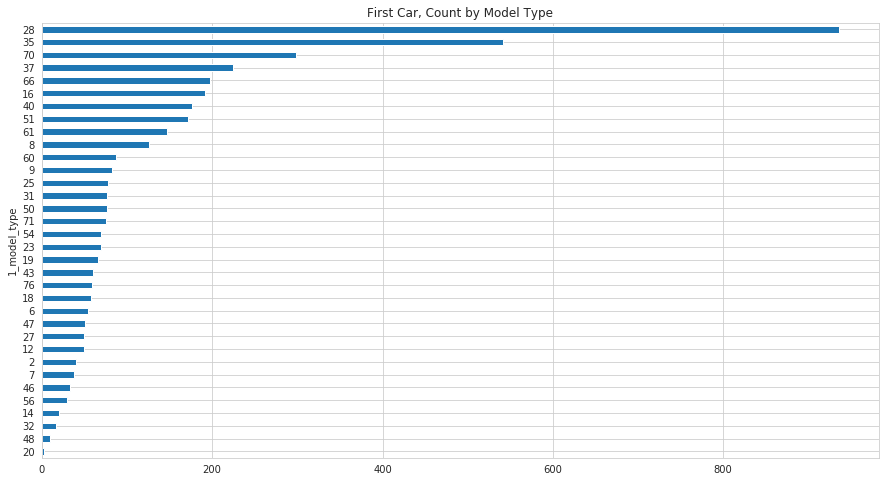

In [0]:
train_expanded.groupby('1_model_type')['ImageId'] \
    .count() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 8),
          title='First Car, Count by Model Type',
          color=my_pal[0])
plt.show()


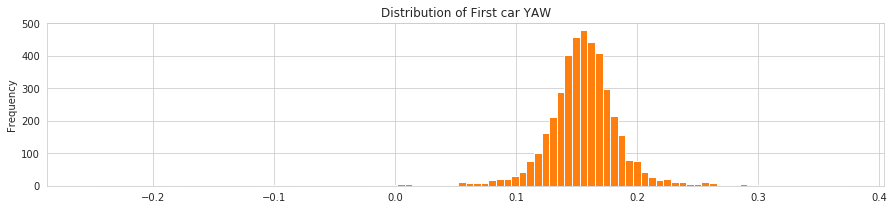

In [0]:
train_expanded['1_yaw'] = pd.to_numeric(train_expanded['1_yaw'])
train_expanded['1_yaw'] \
    .dropna() \
    .plot(kind='hist',
          figsize=(15, 3),
          bins=100,
          title='Distribution of First car YAW',
          color=my_pal[1])
plt.show()

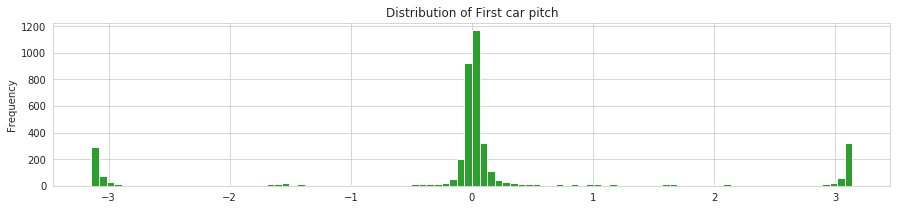

In [0]:
train_expanded['1_pitch'] = pd.to_numeric(train_expanded['1_pitch'])
train_expanded['1_pitch'] \
    .dropna() \
    .plot(kind='hist',
          figsize=(15, 3),
          bins=100,
          title='Distribution of First car pitch',
          color=my_pal[2])
plt.show()

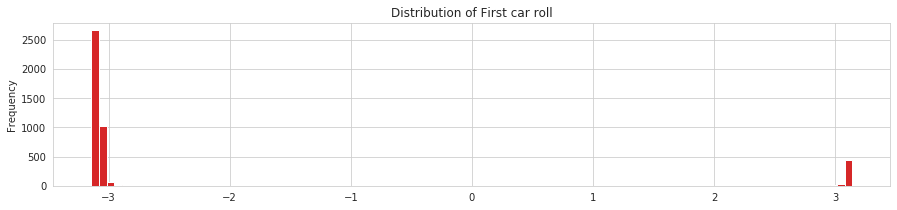

In [0]:
train_expanded['1_roll'] = pd.to_numeric(train_expanded['1_roll'])
train_expanded['1_roll'] \
    .dropna() \
    .plot(kind='hist',
          figsize=(15, 3),
          bins=100,
          title='Distribution of First car roll',
          color=my_pal[3])
plt.show()

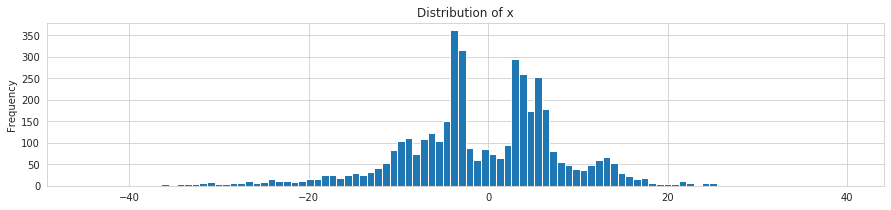

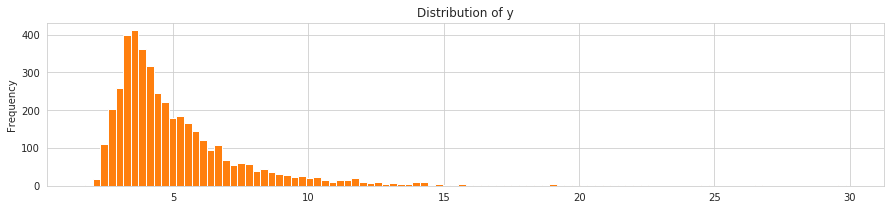

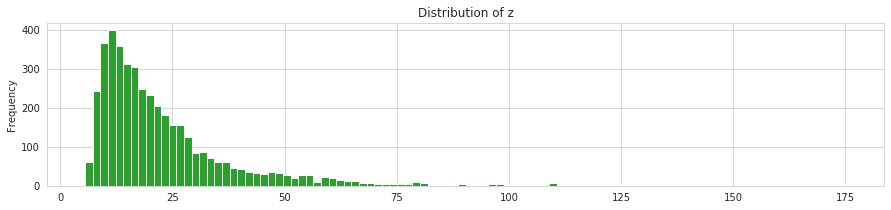

In [0]:
train_expanded['1_x'] = pd.to_numeric(train_expanded['1_x'])
train_expanded['1_y'] = pd.to_numeric(train_expanded['1_y'])
train_expanded['1_z'] = pd.to_numeric(train_expanded['1_z'])
train_expanded['1_x'] \
    .dropna() \
    .plot(kind='hist',
          figsize=(15, 3),
          bins=100,
          title='Distribution of x',
          color=my_pal[0])
plt.show()
train_expanded['1_y'] \
    .dropna() \
    .plot(kind='hist',
          figsize=(15, 3),
          bins=100,
          title='Distribution of y',
          color=my_pal[1])
plt.show()
train_expanded['1_z'] \
    .dropna() \
    .plot(kind='hist',
          figsize=(15, 3),
          bins=100,
          title='Distribution of z',
          color=my_pal[2])
plt.show()

In [0]:
test.head()

ImageId             PredictionString
0  ID_18fb86d04  0.5 0.5 0.5 0.0 0.0 0.0 1.0
1  ID_ce06d4dc1  0.5 0.5 0.5 0.0 0.0 0.0 1.0
2  ID_afe07078f  0.5 0.5 0.5 0.0 0.0 0.0 1.0
3  ID_37caf75aa  0.5 0.5 0.5 0.0 0.0 0.0 1.0
4  ID_7655363ca  0.5 0.5 0.5 0.0 0.0 0.0 1.0

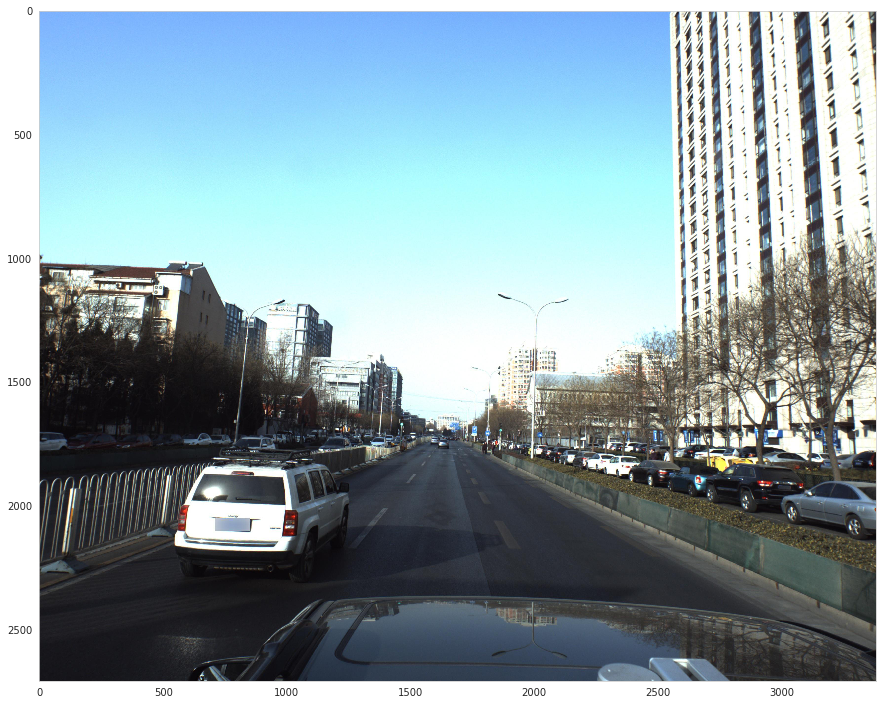

In [0]:
plt.rcParams["axes.grid"] = False
train_ids = train['ImageId'].values
img_name = train.loc[2742]['ImageId']
fig, ax = plt.subplots(figsize=(15, 15))
img1 = load_img('train_images/' + img_name + '.jpg')
plt.imshow(img1)
plt.show()

In [0]:
!cat camera/camera_intrinsic.txt

fx = 2304.5479;
fy = 2305.8757;
cx = 1686.2379;
cy = 1354.9849;

In [0]:
with open('car_models_json/mazida-6-2015.json') as json_file:
    car_model_data = json.load(json_file)
    print(car_model_data)

{'car_type': '3x', 'vertices': [[0.9123247449999999, -0.35116389, 0.6488181000000001], [0.912059215, -0.35171402999999996, 0.61499762], [0.9120099450000001, -0.35190621, 0.61502179], [0.9115305050000001, -0.35118825000000004, 0.6488147999999999], [0.9106789750000001, -0.35725819999999997, 0.6148787800000001], [0.907556305, 0.40800611, -1.09027102], [0.907502125, -0.35097945, 0.66198493], [0.9067142149999999, -0.30757206, 0.61665227], [0.906072985, 0.5797642900000001, -1.48057336], [0.906072985, 0.5739296199999999, -1.25142859], [0.906072985, 0.56390028, -1.50339157], [0.906072985, 0.55713062, -1.22928964], [0.906072985, 0.34777329, -1.57975044], [0.906072985, 0.3373979, -1.1640289400000001], [0.906072985, 0.32116948, -1.5717138700000002], [0.906072985, 0.31115175, -1.17316427], [0.906072985, 0.18176129, -1.38976134], [0.906072985, 0.1811834, -1.36197646], [0.905806325, 0.59192299, -1.4596305799999998], [0.905806325, 0.58681048, -1.27175479], [0.905806325, 0.54854916, -1.52192332], [0.9

In [0]:
for keys in enumerate(car_model_data):
    print(keys)

(0, 'car_type')
(1, 'vertices')
(2, 'faces')


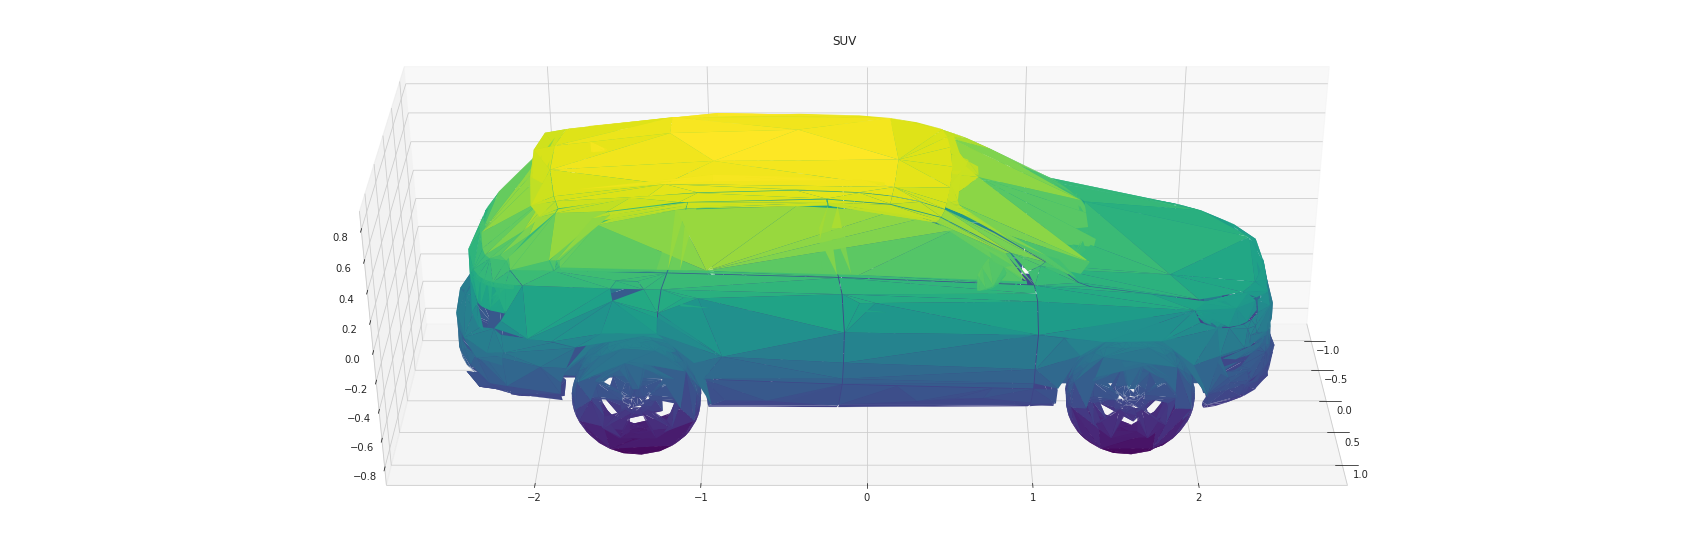

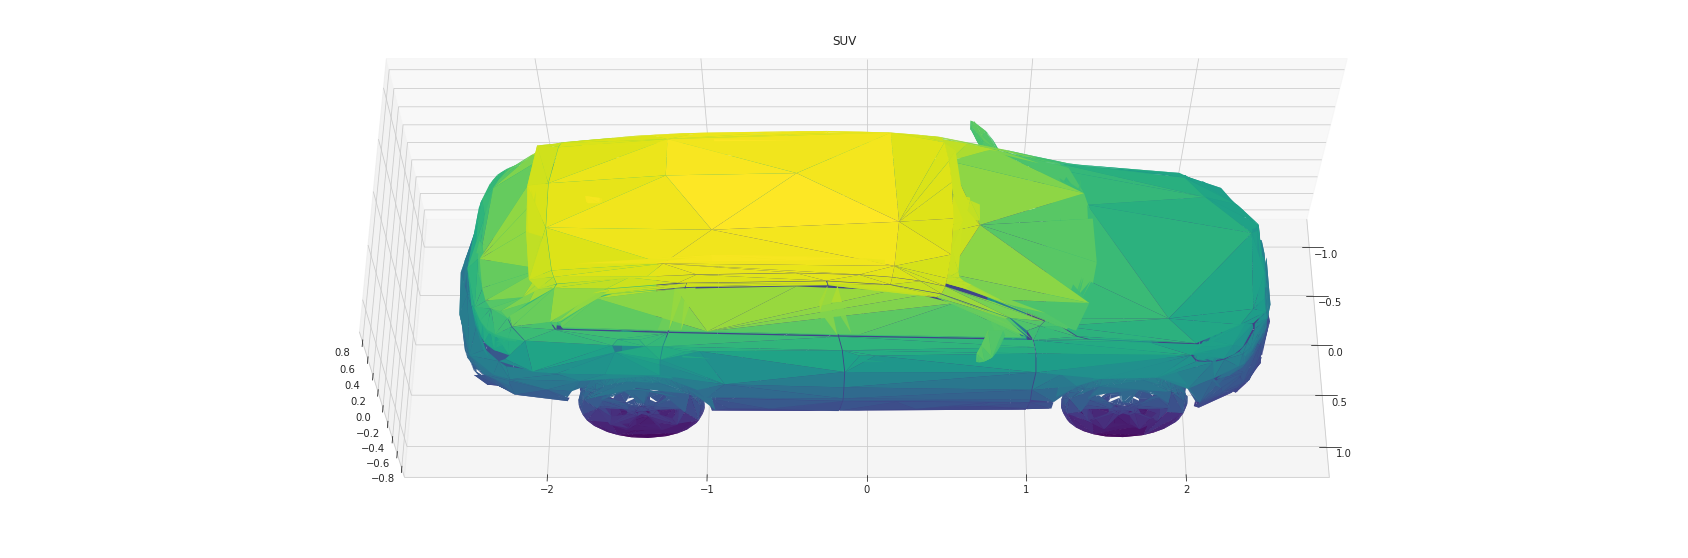

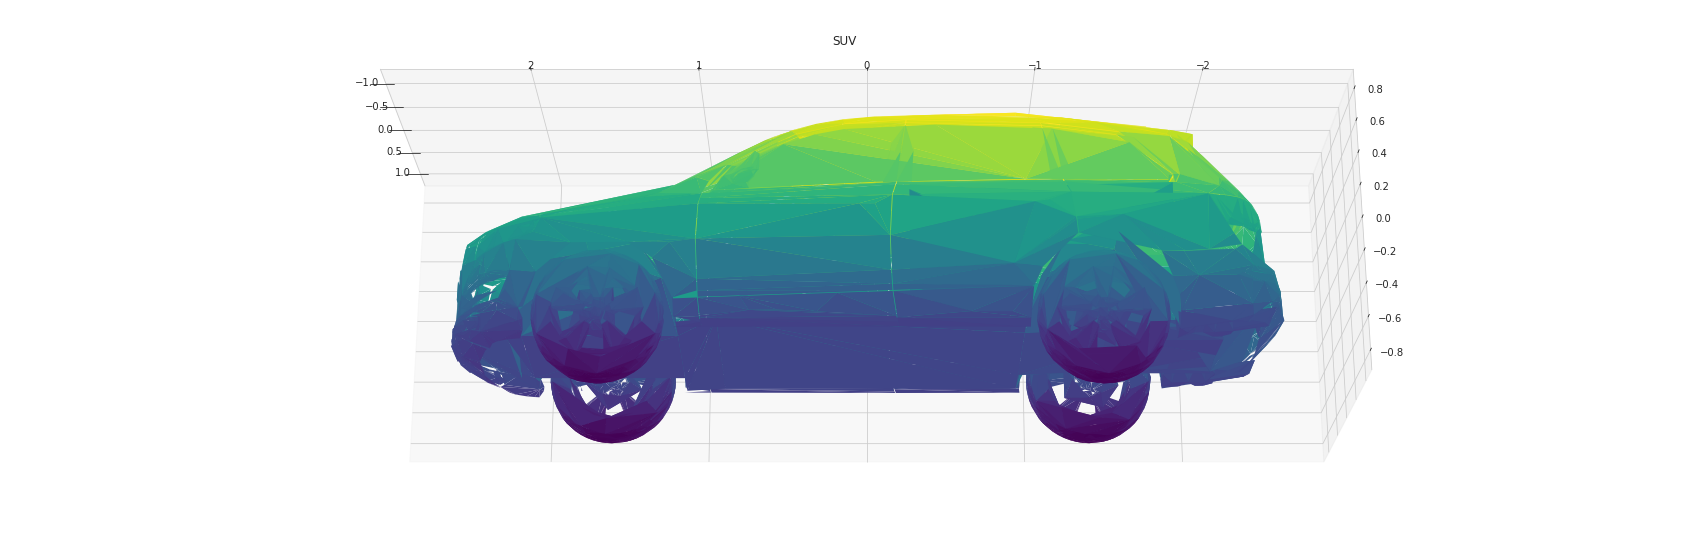

In [0]:
def plot_3d_car(model_json_file):
    with open(f'car_models_json/{model_json_file}') as json_file:
        car_model_data = json.load(json_file)

    vertices = np.array(car_model_data['vertices'])
    faces = np.array(car_model_data['faces']) - 1
    car_type = car_model_data['car_type']
    x, y, z = vertices[:,0], vertices[:,2], -vertices[:,1]
    fig = plt.figure(figsize=(30, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(x, y, faces, z,
                    cmap='viridis', edgecolor='none')
    ax.set_title(car_type)
    ax.view_init(30, 0)
    plt.show()
    fig = plt.figure(figsize=(30, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(x, y, faces, z,
                    cmap='viridis', edgecolor='none')
    ax.set_title(car_type)
    ax.view_init(60, 0)
    plt.show()
    fig = plt.figure(figsize=(30, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(x, y, faces, z,
                    cmap='viridis', edgecolor='none')
    ax.set_title(car_type)
    ax.view_init(-20, 180)
    plt.show()
    return
plot_3d_car('aodi-Q7-SUV.json')

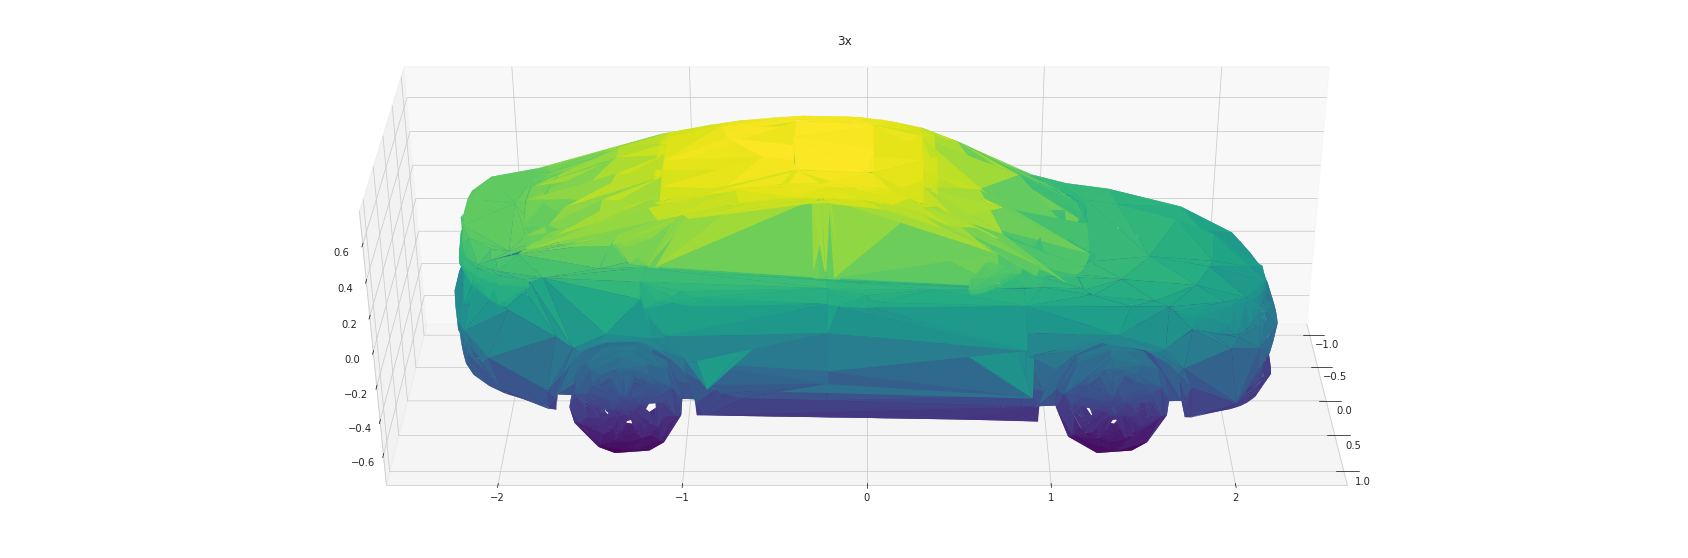

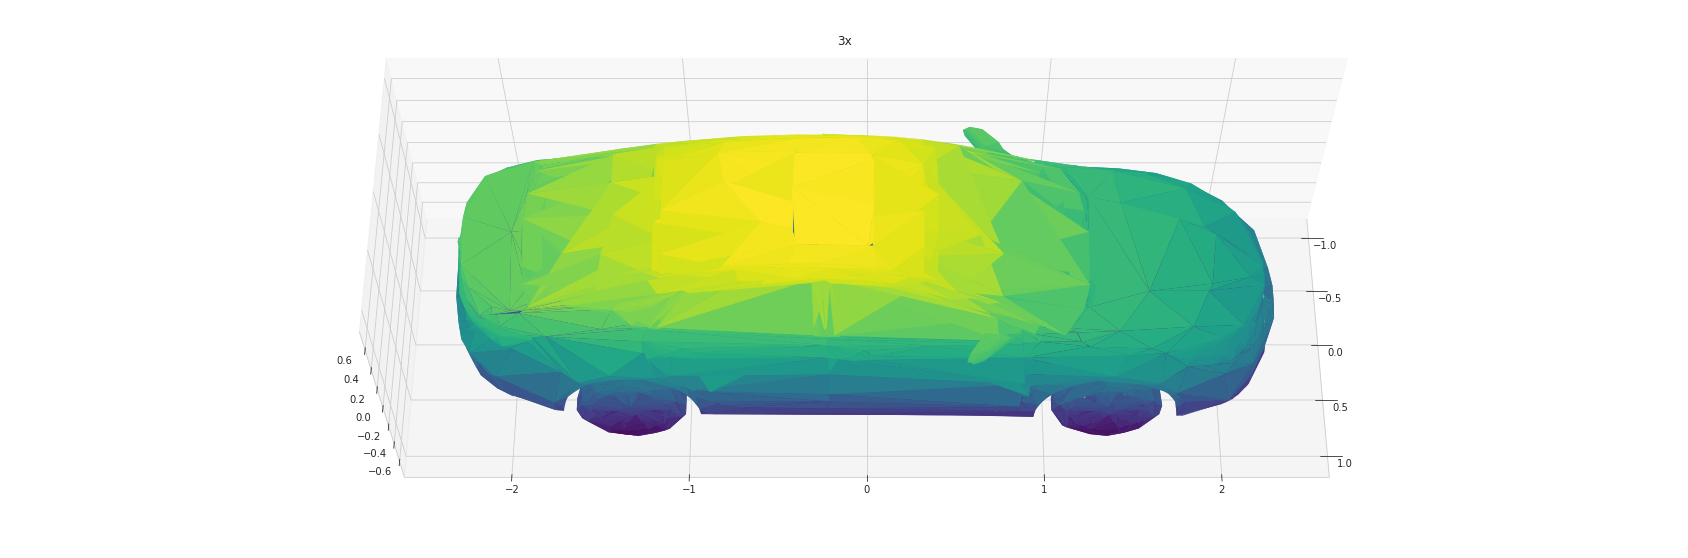

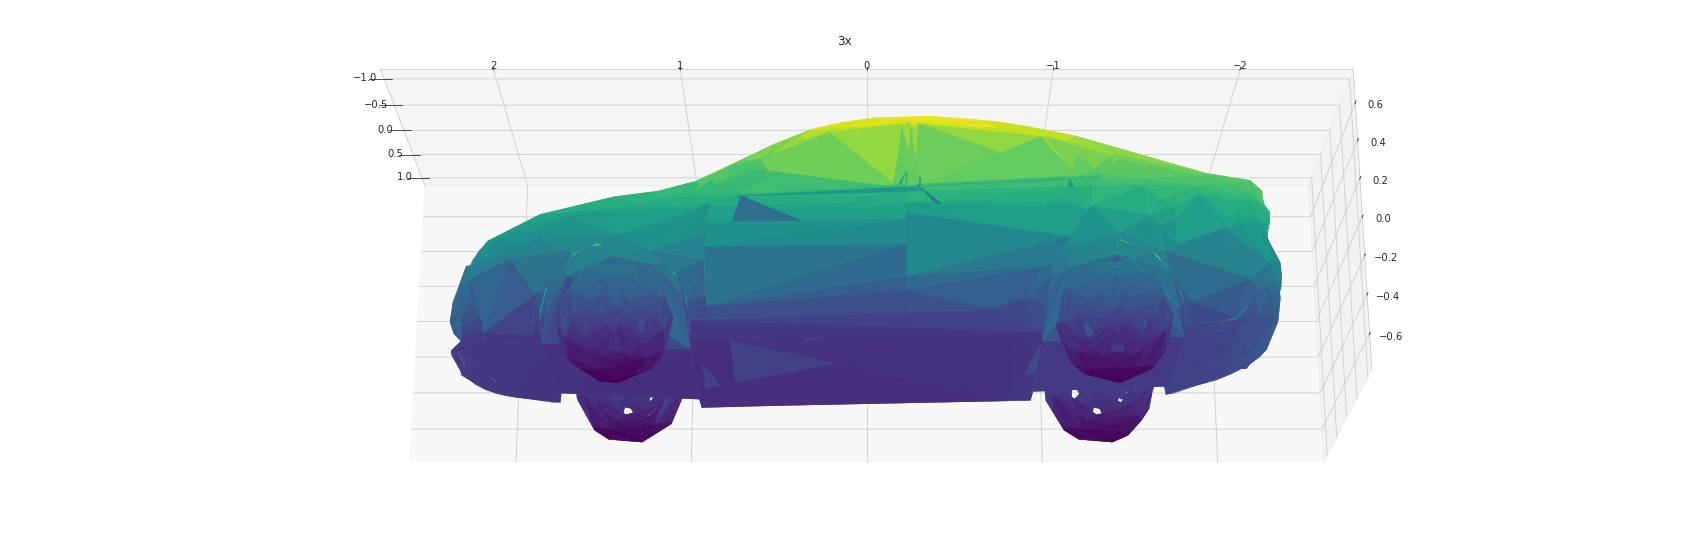

In [0]:
plot_3d_car('MG-GT-2015.json')

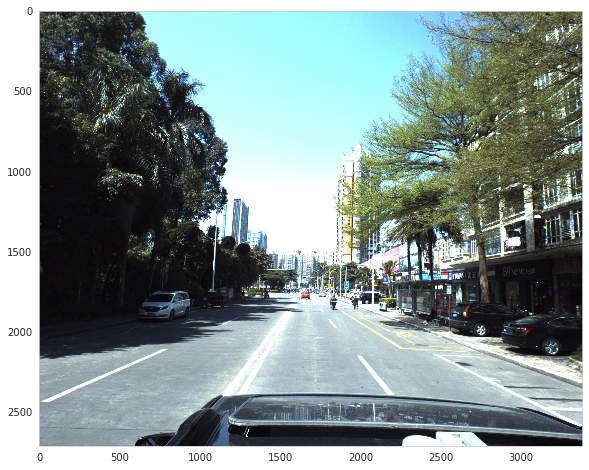

In [0]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread('train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);

In [0]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [0]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


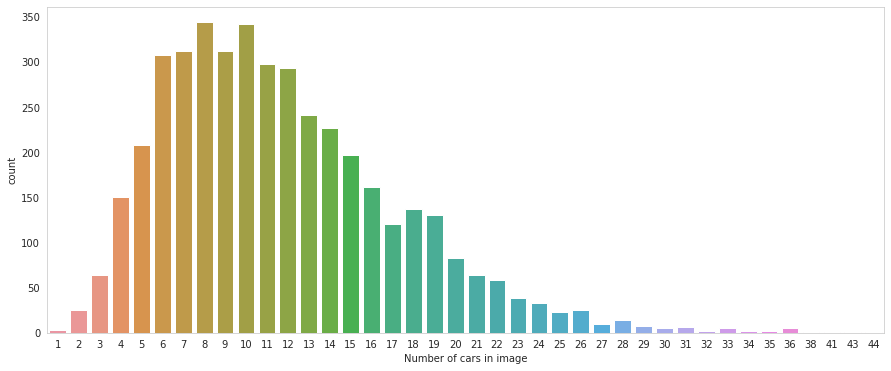

In [0]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

plt.figure(figsize=(15,6))
sns.countplot(lens);
plt.xlabel('Number of cars in image');

In [0]:
#All Points
points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr

print('len(points_df)', len(points_df))
points_df.head()

len(points_df) 49684


x         y        z       yaw    pitch     roll
0   7.96539   3.20066  11.0225  0.254839 -2.57534 -3.10256
1   9.60332   4.66632  19.3390  0.181647 -1.46947 -3.12159
2  10.39000  11.22190  59.7825  0.163072 -1.56865 -3.11754
3  -9.59236   5.13662  24.7337  0.141942 -3.13950  3.11969
4   9.83335  13.26890  72.9323  0.163068 -2.08578 -3.11754

2D Visualization

In [0]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

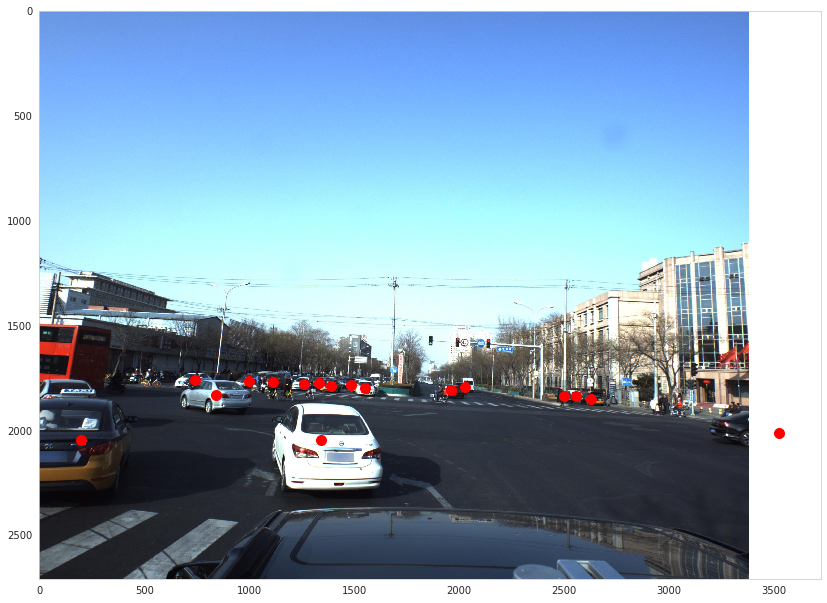

In [0]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread('train_images/' + train['ImageId'][2217] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

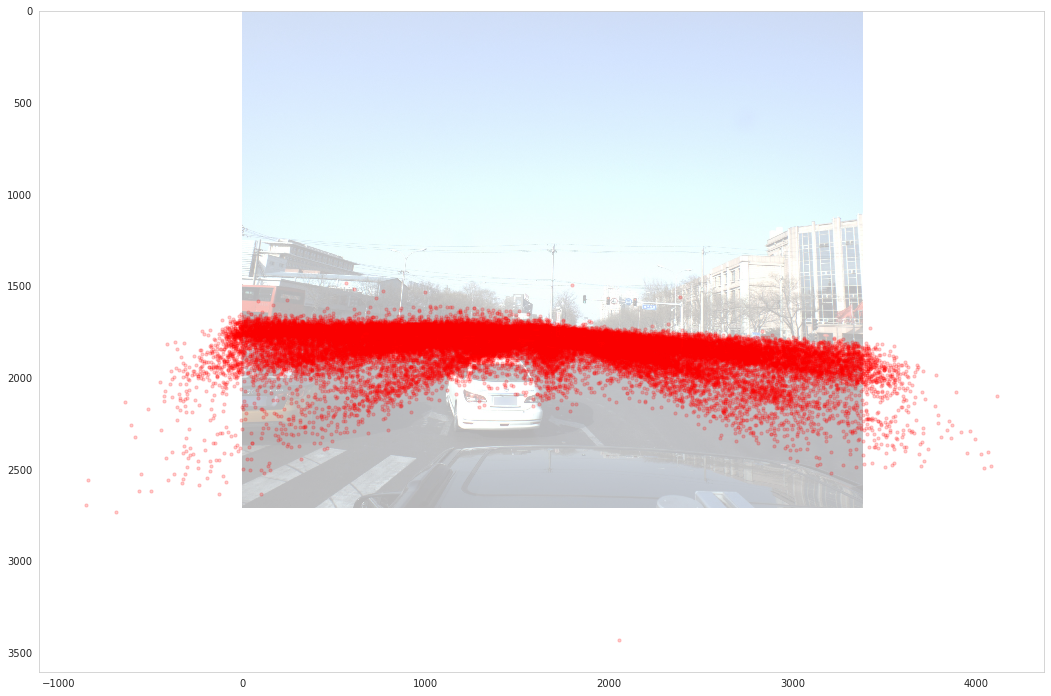

In [0]:
xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(18,18))
plt.imshow(imread('train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

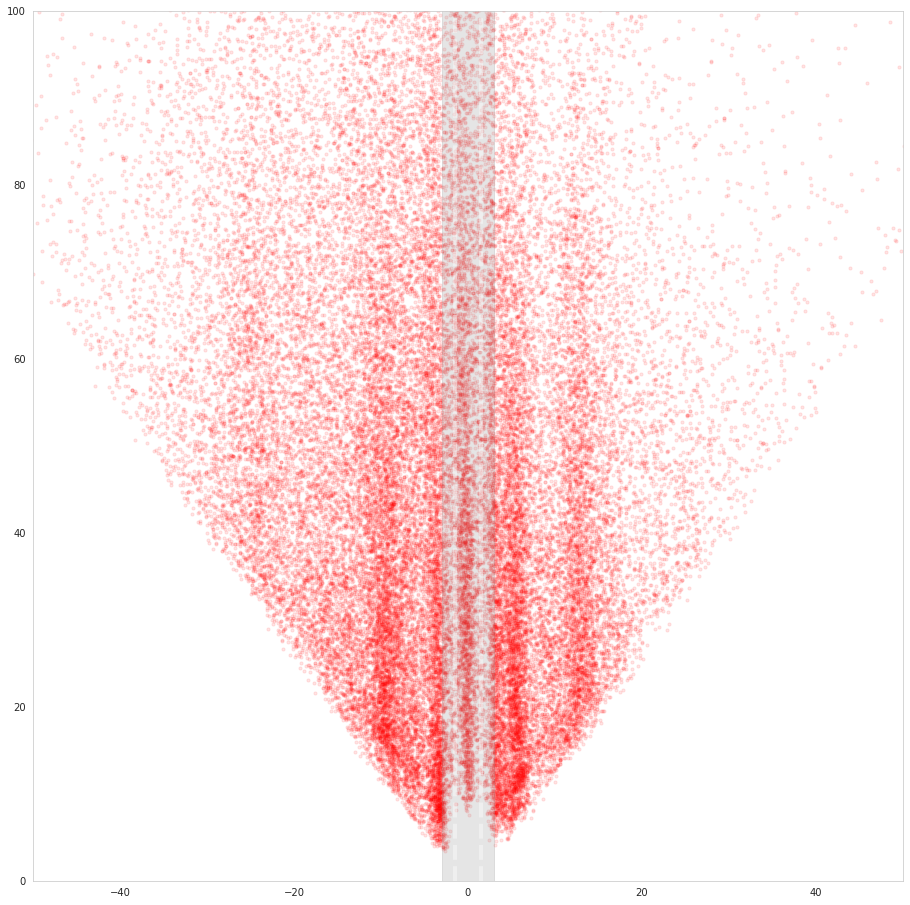

In [0]:
# Road points
road_width = 3
road_xs = [-road_width, road_width, road_width, -road_width, -road_width]
road_ys = [0, 0, 500, 500, 0]

plt.figure(figsize=(16,16))
plt.axes().set_aspect(1)
plt.xlim(-50,50)
plt.ylim(0,100)

# View road
plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
plt.plot([road_width/2,road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
plt.plot([-road_width/2,-road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
# View cars
plt.scatter(points_df['x'], np.sqrt(points_df['z']**2 + points_df['y']**2), color='red', s=10, alpha=0.1);

In [0]:
fig = px.scatter_3d(points_df, x='x', y='y', z='z',color='pitch', range_x=(-50,50), range_y=(0,50), range_z=(0,250), opacity=0.1)
fig.show()

In [0]:
zy_slope = LinearRegression()
X = points_df[['z']]
y = points_df['y']
zy_slope.fit(X, y)
print('MAE without x:', mean_absolute_error(y, zy_slope.predict(X)))

# Will use this model later
xzy_slope = LinearRegression()
X = points_df[['x', 'z']]
y = points_df['y']
xzy_slope.fit(X, y)
print('MAE with x:', mean_absolute_error(y, xzy_slope.predict(X)))

print('\ndy/dx = {:.3f}\ndy/dz = {:.3f}'.format(*xzy_slope.coef_))

MAE without x: 0.6553782352986744
MAE with x: 0.4481661289004144

dy/dx = 0.051
dy/dz = 0.169


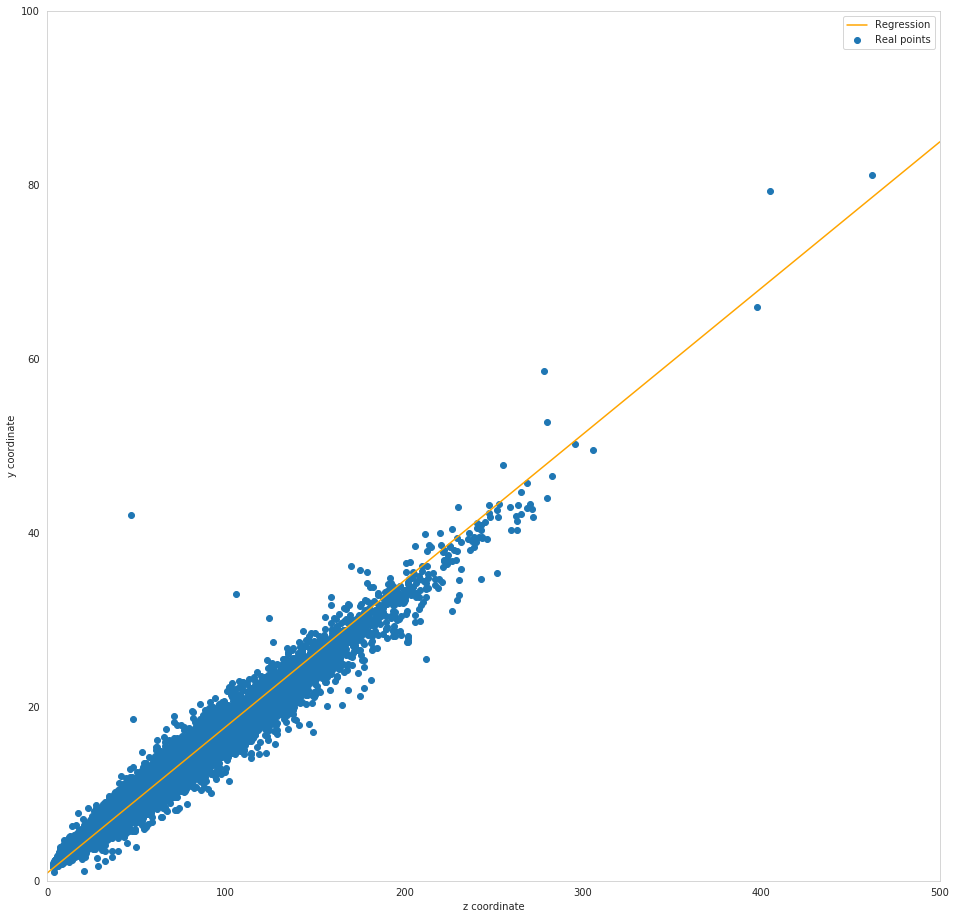

In [0]:
plt.figure(figsize=(16,16))
plt.xlim(0,500)
plt.ylim(0,100)
plt.scatter(points_df['z'], points_df['y'], label='Real points')
X_line = np.linspace(0,500, 10)
plt.plot(X_line, zy_slope.predict(X_line.reshape(-1, 1)), color='orange', label='Regression')
plt.legend()
plt.xlabel('z coordinate')
plt.ylabel('y coordinate');

3D Visualization

In [0]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [0]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [0]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [0]:
n_rows = 6

for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread('train_images/' + train['ImageId'].iloc[idx] + '.jpg')
    axes[0].imshow(img)
    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
    axes[1].imshow(img_vis)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Image Preprocessing

In [0]:
IMG_WIDTH = 1024
IMG_HEIGHT = IMG_WIDTH // 16 * 5
MODEL_SCALE = 8

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        for k in ['x', 'pitch', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img, flip=False):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 6]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    if flip:
        img = img[:,::-1]
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels, flip=False):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 6) * IMG_WIDTH / (img.shape[1] * 4/3) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict, flip)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    if flip:
        mask = np.array(mask[:,::-1])
        regr = np.array(regr[:,::-1])
    return mask, regr

img.shape (320, 1024, 3) std: 0.29819912
mask.shape (40, 128) std: 0.031234737
regr.shape (40, 128, 7) std: 0.013211883


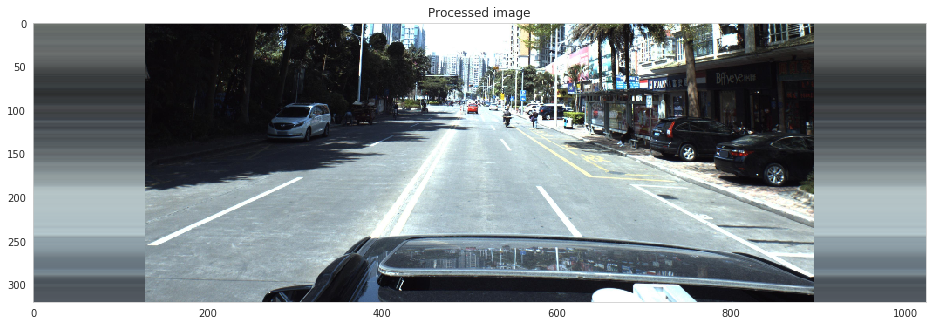

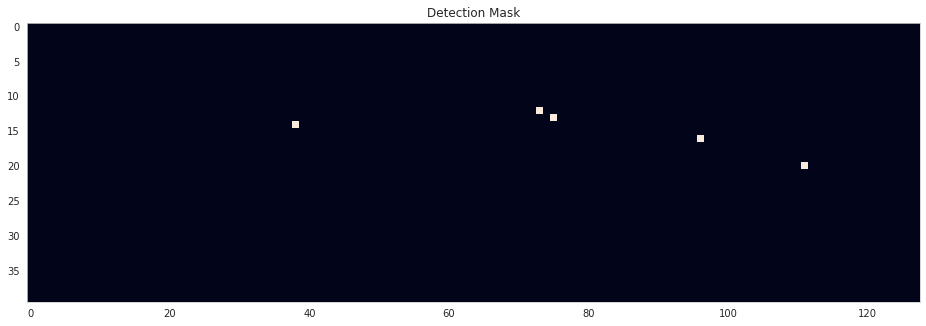

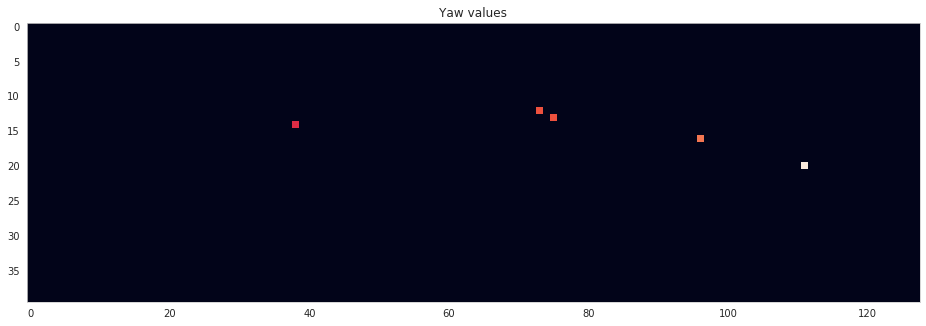

In [0]:
img0 = imread('train_images/' + train['ImageId'][0] + '.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, train['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

In [0]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0, flipped=False):
    def distance_fn(xyz):
        x, y, z = xyz
        xx = -x if flipped else x
        slope_err = (xzy_slope.predict([[xx,z]])[0] - y)**2
        x, y = convert_3d_to_2d(x, y, z)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        y = (y + IMG_SHAPE[1] // 6) * IMG_WIDTH / (IMG_SHAPE[1] * 4 / 3) / MODEL_SCALE
        return max(0.2, (x-r)**2 + (y-c)**2) + max(0.4, slope_err)
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z_new

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, flipped=False):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > 0)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = \
                optimize_xy(r, c,
                            coords[-1]['x'],
                            coords[-1]['y'],
                            coords[-1]['z'], flipped)
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [0]:
for idx in range(2):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    
    for ax_i in range(2):
        img0 = imread( 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
        if ax_i == 1:
            img0 = img0[:,::-1]
        img = preprocess_image(img0, ax_i==1)
        mask, regr = get_mask_and_regr(img0, train['PredictionString'][idx], ax_i==1)
        regr = np.rollaxis(regr, 2, 0)
        coords = extract_coords(np.concatenate([mask[None], regr], 0), ax_i==1)
        
        axes[ax_i].set_title('Flip = {}'.format(ax_i==1))
        axes[ax_i].imshow(visualize(img0, coords))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

PyTorch Dataset

In [0]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Augmentation
        flip = False
        if self.training:
            flip = np.random.randint(10) == 1
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0, flip=flip)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        mask, regr = get_mask_and_regr(img0, labels, flip=flip)
        regr = np.rollaxis(regr, 2, 0)
        
        return [img, mask, regr]

In [0]:
train_images_dir = 'train_images/{}.jpg'
test_images_dir = 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, training=True)
dev_dataset = CarDataset(df_dev, train_images_dir, training=False)
test_dataset = CarDataset(df_test, test_images_dir, training=False)

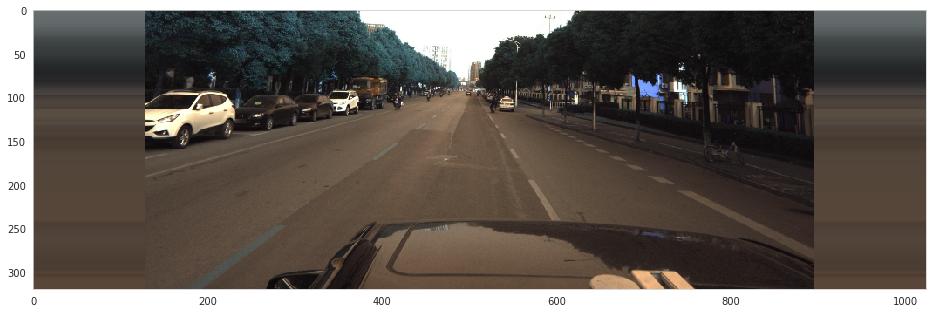

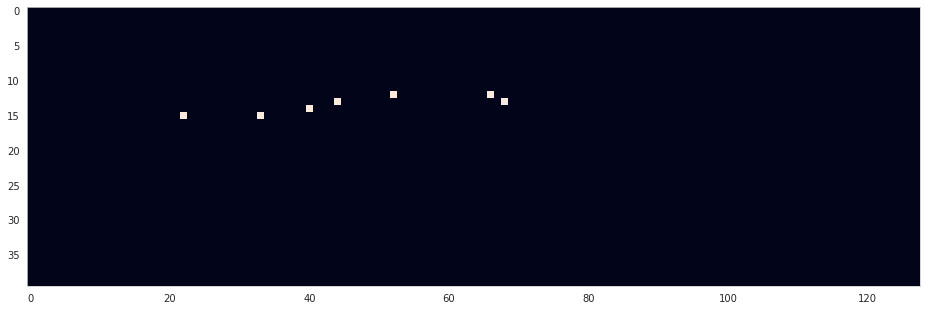

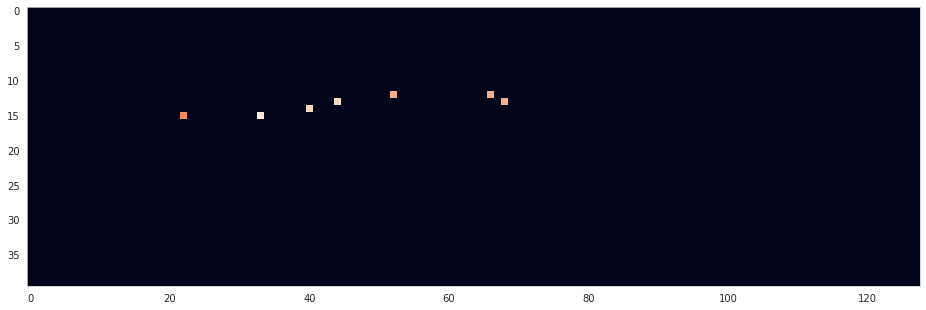

In [0]:
img, mask, regr = train_dataset[0]

plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [0]:
BATCH_SIZE = 4
# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

PyTorch Model


In [0]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=5d544fcd42f32152940255484647f75596e719cbe747df6b459d8ce74d937dc9
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built efficientnet-pytorch


In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

       
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
       
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [0]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [0]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 10

model = MyUNet(8).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.00, rho=0.95, eps=1e-08,)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 45.3MB/s]


Loaded pretrained weights for efficientnet-b0


Training

In [0]:
def criterion(prediction, mask, regr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    
    # Sum
    loss = mask_loss + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [0]:
def train_model(epoch, history=None):
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))

def evaluate_model(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    print('Dev loss: {:.4f}'.format(loss))

In [0]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)

100%|██████████| 1055/1055 [17:41<00:00,  1.64it/s]


Train Epoch: 0 	LR: 1.000000	Loss: 33.119610


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 28.8769


100%|██████████| 1055/1055 [17:37<00:00,  1.59it/s]


Train Epoch: 1 	LR: 1.000000	Loss: 19.141619


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 25.9017


100%|██████████| 1055/1055 [17:23<00:00,  1.65it/s]


Train Epoch: 2 	LR: 1.000000	Loss: 22.377867
Dev loss: 23.5280


100%|██████████| 1055/1055 [17:20<00:00,  1.59it/s]


Train Epoch: 3 	LR: 0.100000	Loss: 17.831007
Dev loss: 22.6046


100%|██████████| 1055/1055 [17:19<00:00,  1.72it/s]


Train Epoch: 4 	LR: 0.100000	Loss: 47.069611
Dev loss: 23.1556


100%|██████████| 1055/1055 [17:11<00:00,  1.67it/s]


Train Epoch: 5 	LR: 0.100000	Loss: 29.767359
Dev loss: 23.3667


100%|██████████| 1055/1055 [18:00<00:00,  1.69it/s]


Train Epoch: 6 	LR: 0.010000	Loss: 21.132437
Dev loss: 23.9984


100%|██████████| 1055/1055 [16:58<00:00,  1.66it/s]


Train Epoch: 7 	LR: 0.010000	Loss: 17.176708
Dev loss: 24.3558


100%|██████████| 1055/1055 [16:43<00:00,  1.74it/s]


Train Epoch: 8 	LR: 0.010000	Loss: 13.634765


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 24.6325


100%|██████████| 1055/1055 [16:34<00:00,  1.57it/s]


Train Epoch: 9 	LR: 0.001000	Loss: 26.728157
Dev loss: 24.7368
CPU times: user 46min 57s, sys: 5min 50s, total: 52min 47s
Wall time: 2h 54min 55s


In [0]:
#%cd content 
%cd drive/My Drive
!pwd
torch.save(model.state_dict(), './model_adadelta_10ep_lr1.pth')

!ls

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive
/content/drive/My Drive
 250-Assignments
"271-Spring'19"
'Adder & Subtractor.pptx'
 Cisco_WebEx_Add-On.dmg
 CMPE243
 code
 code_test
'Colab Notebooks'
 Compiler.docx
'Delay in Verilog.docx'
'Design of a DNN Inference Engine Using Quantization and Retraining Technique.gdoc'
'EE258 - Project II'
'HW cover page.docx'
 I20-Nivedita.pdf
 __Important_Information_Verilog_EE271.pdf
 _info
 Internship
'J K FF info.docx'
'Lec 01.pdf'
'Lec 02-2 k-maps.pdf'
'Lec 02.pdf'
'Lec 03-1 Hazard TL.pdf'
'Lec 07.pdf'
'Lec 09 Timing.pdf'
'Literature Survey'
'Mid II sol (1).pdf'
'Mid II sol.pdf'
 model_adadelta_10ep_lr1.pth
 model.pth
 PPT
'Project II - EE258.gslides'
 py9.py
 received_1207721949312501-1.jpg
'Reference Papers'
 Report
 SecureMessageAtt.html
'SELF-DRIVING CARS POWERED WITH ARTFICIAL INTELLIGENCE(AI) - Final Paper Draft (1).gdoc'
'SELF-DRIVING CARS POWERED WITH ARTFICIAL INTELLIGENCE(AI) - Final Paper Draft.gdoc'
 swe

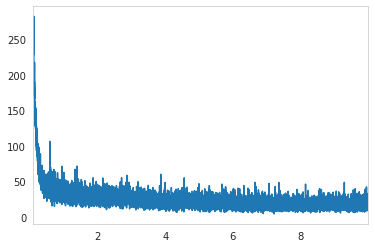

In [0]:
history['train_loss'].iloc[100:].plot();

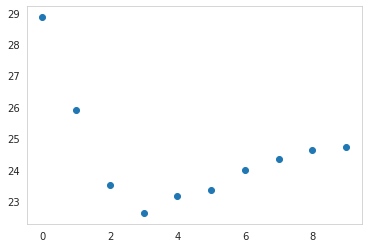

In [0]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

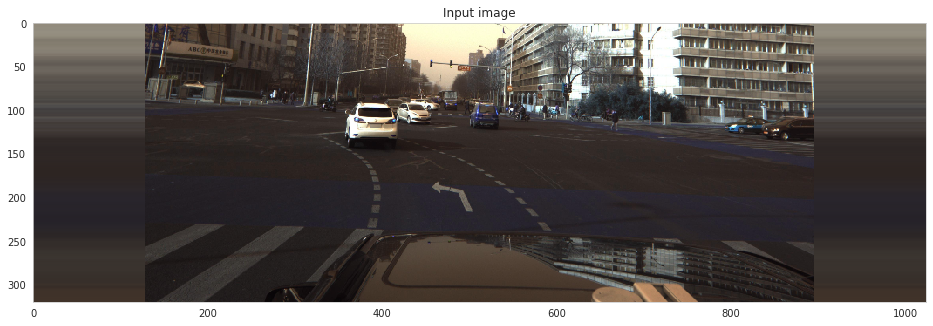

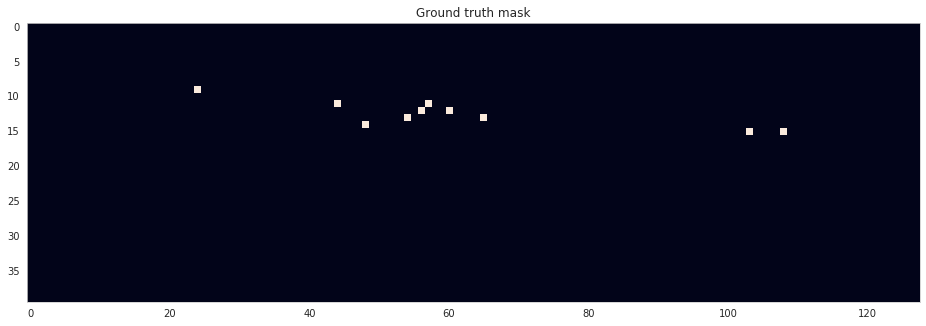

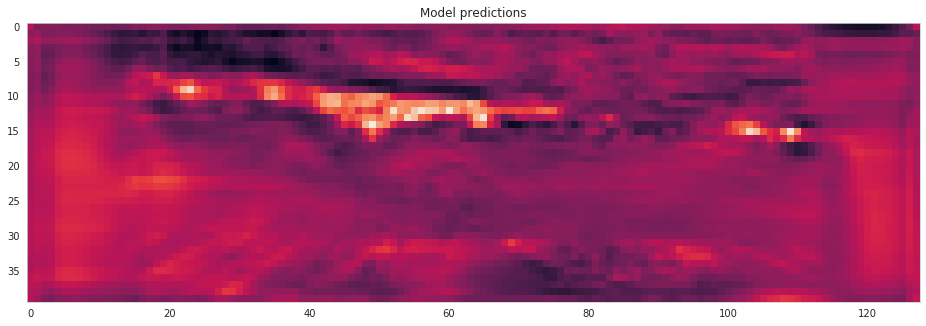

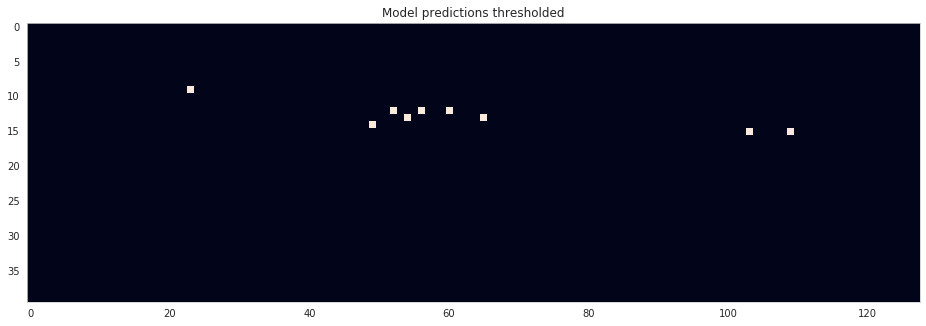

In [0]:
img, mask, regr = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

In [0]:
torch.cuda.empty_cache()
gc.collect()

for idx in range(8):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

100%|██████████| 506/506 [10:48<00:00,  1.65it/s]


In [0]:
test = pd.read_csv( 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
test.head()
test.info

FileNotFoundError: ignored

In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 2 columns):
ImageId             2021 non-null object
PredictionString    2021 non-null object
dtypes: object(2)
memory usage: 31.7+ KB


In [0]:
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df



def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
   
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

In [0]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(test['ImageId'],test['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores

In [0]:
df_dev.head()

ImageId                                   PredictionString
3880  ID_e91f42875  7 0.0746616 1.72916 -3.12357 22.9398 7.39416 3...
1293  ID_11c2b877f  47 0.164366 0.0118918 -3.05636 -3.85339 5.6797...
1784  ID_75004f45a  25 0.160625 -2.92549 -3.14081 -9.76604 3.97509...
3858  ID_d10a385ea  61 0.179841 0.0947117 -3.05333 6.1466 4.51087 ...
4193  ID_bc5effdb6  16 0.174616 0.040944 -3.08661 1.7252 5.65201 2...